## 导入库

In [1]:
# encoding: UTF-8
import re
import os
import numpy as np
import scipy.io as sio
from Bio import SeqIO
import tensorflow as tf
from time import time
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## 氨基酸序列的ONE-HOT编码

In [2]:
# 把一个氨基酸序列转换为一个ONE HOT二维数组。氨基酸序列长度为N，数组是N-by-21，21表示 'GAVLIPFYWSTCMNQDEKRHX'这21个氨基酸缩写字符
def seq2OneHotArray(sequence):
    N = len(sequence)
    result = np.zeros(shape=(N,21),dtype=np.int32)
    alphabet = 'GAVLIPFYWSTCMNQDEKRHX'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    digseq = [char_to_int[char] for char in sequence]
    for i in range(N):
        result[i][digseq[i]] = 1
    return result        

## 根据序列的fasta文件构建数据集

In [3]:
def establishBenchmarkOneHot(fastaFile, saveFile):
    SeqOneHot = {}
    for seq_record in SeqIO.parse(fastaFile, 'fasta'):
        s = seq_record.seq
        r = seq2OneHotArray(s)
        SeqOneHot[seq_record.name] = r
   
    sio.savemat(saveFile,SeqOneHot)
    

## 根据binding site文件，构建数据集。按滑窗的方法，滑窗大小ws
  - positive 是binting site序列
  - negative 是not binding site

In [4]:
# 滑窗，不足的以头尾循环补
def splitWindows(ws, matFile, sitesFile, saveFile):
    SeqOneHot = sio.loadmat(matFile)
    X = []
    Y = []
    k = 0
    t = 0
    with open(sitesFile, 'r') as pbsreader:
        for line in pbsreader:
            line = line.strip()
            if '>' in line:
                sid = line[1:]
                p = SeqOneHot[sid]
                seqlen = p.shape[0]
                col = np.size(p,1)
                for j in range(seqlen):
                    #create a array
                    d = np.zeros(shape=(ws*2+1,col), dtype=np.int32)
                    if j < ws:
                        d[0:ws-j] = p[j-ws:]
                        d[ws-j:2*ws+1] = p[0: ws+j+1]
                    elif j > seqlen - ws -1:
                        d[0:ws] = p[j-ws:j]
                        d[ws:ws + seqlen -j] = p[j:]
                        d[ws+seqlen-j:] = p[0:ws-seqlen+j+1]
                    else:
                        d[::]=p[j-ws:j+ws+1]
                        
                    X.insert(k,d)
                    Y.append([1,0])
                    k += 1
            else:
                sites = line.split()
                for s in sites:
                    idx = eval(s)
                    Y[t + idx -1] = [0,1]
                t=k  
      
    bindingsite = {}
    negative = []
    positive = []
    for x,y in zip(X,Y):
        if y[0] == 1:
            negative.append(x)
        else:
            positive.append(x)
    
    bindingsite = {
        'negative': negative,
        'positive': positive
    }
    
    sio.savemat(saveFile,bindingsite)


## 对非平衡数据的处理
 - 逐步剪切并对称翻转。剪切头尾的氨基酸，以0填充，并翻转，生成新的人工数据

In [5]:
def reverseColumn(x):
    temp = np.zeros((1,31,21), dtype=np.int32)
    for i in range(21):
        temp[0,:,i] = x[:,20-i]
    return temp

def SMote(dataset):
    result = dataset
    
    k = dataset.shape[1]
    for x in dataset:
        result = np.append( result, reverseColumn(x),axis=0)
        for k in range(5):
            x[:,k] = 0
            x[:,-(k+1)] = 0
            result = np.append(result, [x], axis=0)
            result = np.append( result, reverseColumn(x), axis=0)
            
    return result

## 定义CNN的共享函数

In [6]:
#定义权值
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='weight')

#定义偏置
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name='bias')

#定义卷积操作
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID') #VALID

#定义最大池化操作
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#定义平均池化操作
def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


## 定义卷积神经网络
  - 返回测试集预测结果

In [7]:
def cnn(x_train, x_test, y_train, y_test):
    X_TRAIN_SIZE = int(x_train.shape[0])
    TRAIN_EPOCHES = 30
    BATCH_SIZE = 50
    TOTAL_BATCH = int( np.ceil( X_TRAIN_SIZE / BATCH_SIZE))
    
    x_train = np.reshape(x_train,[-1,31,21,1])
    x_test = np .reshape(x_test,[-1,31,21,1])
    #输入层 31-by-21
    with tf.name_scope('input_layer'):
        x = tf.placeholder(tf.float32, shape=[None, 31, 21, 1], name='x')

    #第1个卷积层
    with tf.name_scope('conv_1'):
        W1 = weight([11,21,1,32])
        b1 = bias([32])
        conv_1 = conv2d(x, W1) + b1
        conv_2 = tf.nn.relu(conv_1)

    #第1个池化层 16-by-11
    with tf.name_scope('pool_1'):
        pool_1 = max_pool_2x2(conv_1)

#     #第2个卷积层
#     with tf.name_scope('conv_2'):
#         W2 = weight([5,5,32,64])
#         b2 = bias([64])
#         conv_2 = conv2d(pool_1, W2) + b2
#         conv_2 = tf.nn.relu(conv_2)

#     #第2个池化层 8-by-6
#     with tf.name_scope("pool_2"):
#         pool_2 = max_pool_2x2(conv_2)

#     #第3个卷积层
#     with tf.name_scope('conv_3'):
#         W3 = weight([3,3,64,128])
#         b3 = bias([128])
#         conv_3 = conv2d(pool_2, W3) + b3
#         conv_3 = tf.nn.relu(conv_3)

#     #第3个池化层 4-by-3
#     with tf.name_scope('pool_3'):
#         pool_3 = max_pool_2x2(conv_3)

    #全连接层
    with tf.name_scope('fc'):
        #将最后一个池化层的128个通道的4-by-3的图像转换为一维向量，长度是128*4*3=1536
#         W4 = weight([1536,256]) #全连接层定义256个神经元
#         b4 = bias([256])
#         flat = tf.reshape(pool_3, [-1, 1536])
#         h = tf.nn.relu(tf.matmul(flat, W4)) + b4
        
        W4 = weight([11*1*32,256]) #全连接层定义256个神经元
        b4 = bias([256])
        flat = tf.reshape(pool_1, [-1, 11*1*32])
        h = tf.nn.relu(tf.matmul(flat, W4)) + b4
        
        keep_prob = tf.placeholder(tf.float32)
        h_dropout = tf.nn.dropout(h, keep_prob)

    #输出层
    with tf.name_scope('output_layer'):
        W5 = weight([256,2])
        b5 = bias([2])
        pred = tf.nn.softmax(tf.matmul(h_dropout, W5) + b5)
    
    #构建网络模型
    with tf.name_scope("optimizer"):
        #定义占位符
        y = tf.placeholder(tf.int32, shape=[None, 2], name="label")
        #定义损失函数
        loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred,
                                                                                 labels=y))
        
        #选择优化器
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_function)
    
    #定义准确率
    with tf.name_scope("evalulation"):
        correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    #训练模型
    epoch= tf.Variable(0, name='epoch', trainable=False)
    STARTTIME = time()
    start_epoch = 0
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        # 设置检查点存储目录
        ckpt_dir = "log/"
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        #生成saver
        saver = tf.train.Saver(max_to_keep=5)
        # 创建 summary_writer，用于写图文件
        summary_writer = tf.summary.FileWriter(ckpt_dir, sess.graph)
        # 如果有检查点文件，读取最新的检查点文件，恢复各种变量值
        ckpt = tf.train.latest_checkpoint(ckpt_dir )
        if ckpt != None:
            saver.restore(sess, ckpt)     
        else:
            print("Training from scratch.")

        start_epoch= sess.run(epoch)
        print("Training starts form {} epoch.".format(start_epoch+1))
        
        #迭代训练
        for ep in range(start_epoch, start_epoch + TRAIN_EPOCHES):
            x_train, y_train = shuffle(x_train, y_train)
            for i in range(TOTAL_BATCH):
                start = (i * BATCH_SIZE) % X_TRAIN_SIZE
                end = min(start + BATCH_SIZE, X_TRAIN_SIZE)
                batch_x = x_train[start:end]
                batch_y = y_train[start:end]
                
                sess.run(optimizer,feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
                
                
                if i % 100 == 0:
                    print("Step {}".format(i), "finished")

            loss,acc = sess.run([loss_function,accuracy],feed_dict={x: batch_x, y: batch_y, keep_prob:1})
            
            print("Train epoch:", '%02d' % (sess.run(epoch)+1), \
                  "Loss=","{:.6f}".format(loss)," Accuracy=",acc)

            #保存检查点
            #saver.save(sess,ckpt_dir+"DBPSite_cnn_model.cpkt",global_step=ep+1)

            sess.run(epoch.assign(ep+1))
    
        duration =time()-STARTTIME
        print("Train finished takes:",duration)   
    
        #计算测试集上的预测结果
        y_pred = sess.run(pred, feed_dict={x: x_test, y: y_test, keep_prob: 1.0})
        
    return y_pred
        

## 使用K-Fold交叉验证

In [8]:
#对数据集X按KFold划分训练集和测试集
def splitByKFold(X, n=5):
    x_trains = []
    x_tests = []
    kf = KFold(n_splits=n)
    for train_index, test_index in kf.split(X):
        x_train, x_test = X[train_index], X[test_index]
        x_trains.append(x_train)
        x_tests.append(x_test)
     
    return x_trains, x_tests

#把正类样本集和负类样本集分别做K-Fold划分训练集和测试集
#其中正类样本集是少数类集，对其做上采样
#然后把对应的正类样本和负类样本保存在名为"fold_k.npz"的文件中
#fold_k.npz文件中保存以下数据：
#    traindata: 训练样本集 
#    testdata: 测试样本集
#    traintarget: 训练样本分类标签
#    testtarget: 测试样本分类标签
def saveKFoldSMoteData(positive_data, negative_data, n=5):
    for i in range(5):
        x_trains_pos, x_tests_pos = splitByKFold(positive_data, n)
        x_trains_neg, x_tests_neg = splitByKFold(negative_data, n)
        x_train_pos = x_trains_pos[i] #正类训练数据
        x_train_neg = x_trains_neg[i] #负类训练数据
        x_test_pos = x_tests_pos[i] #正类测试数据
        x_test_neg = x_tests_neg[i] #负类测试数据

        x_train_pos = SMote(x_train_pos) #正类训练数据是少数类样本，进行上采样

        k_train_pos = int( len( x_train_pos)) #正类训练样本数
        k_train_neg = int( len( x_train_neg)) #负类训练样本数
        k_test_pos = int( len( x_test_pos)) #正类测试样本数
        k_test_neg = int( len( x_test_neg)) #负类测试样本数

        y_train_pos = np.tile([1,0], (k_train_pos,1))
        y_train_neg = np.tile([0,1], (k_train_neg,1))
        y_test_pos = np.tile([1,0], (k_test_pos,1))
        y_test_neg = np.tile([0,1], (k_test_neg,1))

        x_train = np.append(x_train_pos, x_train_neg, axis=0)
        y_train = np.append(y_train_pos, y_train_neg, axis=0)

        x_test = np.append(x_test_pos, x_test_neg, axis=0)
        y_test = np.append(y_test_pos, y_test_neg, axis=0)

        x_train = x_train.astype(np.float32)
        x_test = x_test.astype(np.float32)

        filename = 'fold_' + str(i) + '.npz'
        np.savez(filename, traindata=x_train, testdata=x_test, traintarget=y_train, testtarget=y_test)
        
def validationKFold(n=5):      
    y_logists = np.ndarray((0,2))
    y_preds = np.ndarray((0,2))
    for i in range(n):
        filename =  'fold_' + str(i) + '.npz'
        D = np.load(filename)
        x_train = D['traindata']
        x_test = D['testdata']
        y_train = D['traintarget']
        y_test = D['testtarget']
        y_pred = cnn(x_train, x_test, y_train, y_test)
        
        y_logists = np.append(y_logists, y_test, axis=0)
        y_preds = np.append(y_preds, y_pred, axis=0)
        
    return y_logists, y_preds

## 计算预测率、混淆矩阵

In [9]:
# 计算预测的准确率
def evalution(y_logists, y_preds):
    correct_prediction = tf.equal(tf.argmax(y_preds, 1),
                                      tf.argmax(y_logists, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    with tf.Session() as sess:
        acc = sess.run(accuracy)
    
    return acc

# 绘制混淆矩阵的函数
# 参数1  cm 混淆矩阵中显示的数值 二维数组
# 参数2 cmap 混淆矩阵中的颜色
# 参数3 title 标题
def plot_confusion_matrix(cm, classes, title='混淆矩阵', cmap=plt.cm.Greens):
    # imshow() 表示绘制并显示二维图 有18个参数
    # 参数1 X 混淆矩阵中显示的数值 二维数组
    # 参数2 cmap 颜色 plt.cm.Blues表示蓝色 plt.cm.Reds表示红色 plt.cm.Greens表示绿色
    # 参数5 interpolation 插值法 一般有如下值
    #     nearest 最近邻插值法
    #     bilinear 双线性插值法
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.imshow(cm, cmap=cmap, interpolation="nearest")
    plt.title(title)  # 标题
    plt.colorbar()  # 显示颜色的进度条
    tick_marks = np.arange(2)  # [0 1]
    plt.xticks(tick_marks, classes)  # 对x轴上分类进行标记
    plt.yticks(tick_marks, classes)  # 对y轴上分类进行标记

    thresh = np.mean(cm)
    for i in range(2):
        for j in range(2):
            plt.text(i, j, cm[j][i],
                     horizontalalignment='center',
                     color='white' if cm[i][j] >= thresh else 'black')

    plt.xlabel('预测值')
    plt.ylabel('真实值')

## 主函数（保存处理后的数据）


In [10]:
%matplotlib inline
#establishBenchmarkOneHot('..\\data\\PDNA-224.fasta','..\\data\\PDNA-224-seqs-OneHot.mat')
#splitWindows(15, '..\\data\\PDNA-224-seqs-OneHot.mat', '..\\data\\PDNA-224-binding-sites.txt', '..\\data\\PDNA-224-OneHot-15.mat')
# bindingsite = sio.loadmat('data\\PDNA-224-OneHot-15.mat')
# negative_data = bindingsite['negative']
# positive_data = bindingsite['positive']
# saveKFoldSMoteData(positive_data, negative_data, 5)

# y_logists, y_preds = validationKFold(5)
# acc = evalution(y_logists, y_preds)
# print("5-Fold prediction accuracy=%.4f" % acc)

# #混淆矩阵
# cnf_matrix = confusion_matrix(y_logists, y_preds)
# print(cnf_matrix)
# recall = cnf_matrix[0][0] / (cnf_matrix[0][0] + cnf_matrix[0][1])
# print('recall: ', recall)
# plot_confusion_matrix(cnf_matrix, [0, 1], cmap=plt.cm.Reds)


# 主函数（训练，测试并画出混淆矩阵）

In [13]:
#对数据进行训练
y_logists, y_preds = validationKFold(5)
acc = evalution(y_logists, y_preds)
print("5-Fold prediction accuracy=%.4f" % acc)


Training from scratch.
Training starts form 1 epoch.
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 01 Loss= 0.362305  Accuracy= 0.95
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 02 Loss= 0.371735  Accuracy= 0.95
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finis

Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 25 Loss= 0.363262  Accuracy= 0.95
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 26 Loss= 0.313270  Accuracy= 1.0
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 27 Loss= 0.313262  Accuracy= 1.0
Step 0 finished
Ste

Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 19 Loss= 0.313407  Accuracy= 1.0
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 20 Loss= 0.313262  Accuracy= 1.0
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 21 Loss= 0.363262  Accuracy= 0.95
S

Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 13 Loss= 0.363579  Accuracy= 0.95
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 14 Loss= 0.363290  Accuracy= 0.95
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 15 Loss= 0.313263

Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 07 Loss= 0.375764  Accuracy= 0.9375
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 08 Loss= 0.337624  Accuracy= 0.96875
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 09 Loss= 0.313274  Accuracy=

Training from scratch.
Training starts form 1 epoch.
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 01 Loss= 0.450546  Accuracy= 0.875
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 02 Loss= 0.337491  Accuracy= 0.96875
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 f

Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 25 Loss= 0.407082  Accuracy= 0.90625
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 26 Loss= 0.407012  Accuracy= 0.90625
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Step 1000 finished
Step 1100 finished
Step 1200 finished
Step 1300 finished
Step 1400 finished
Step 1500 finished
Train epoch: 27 Loss= 0.

[0 0 0 ... 1 1 1] [1 1 1 ... 1 1 1]
[[  293  3485]
 [ 2628 50942]]
recall:  0.07755426151402858


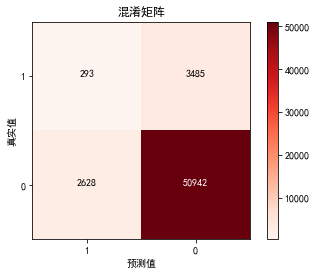

In [14]:
#混淆矩阵
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    #print(y_logists)
    
    a=tf.argmax(y_logists,1)
    b=tf.argmax(y_preds,1)
    xx=sess.run(a)
    yy=sess.run(b)
    print(xx,yy)
    #cnf_matrix = confusion_matrix(y_logists[:,0], y_preds[:,0])
    cnf_matrix = confusion_matrix(xx, yy)
    print(cnf_matrix)
    recall = cnf_matrix[0][0] / (cnf_matrix[0][0] + cnf_matrix[0][1])
    print('recall: ', recall)
    plot_confusion_matrix(cnf_matrix, [1, 0], cmap=plt.cm.Reds)


In [ ]:
'''
Train epoch: 25 Loss= 0.407012  Accuracy= 0.90625
Train finished takes: 205.49364042282104
5-Fold prediction accuracy=0.8939


Train epoch: 25 Loss= 0.907012  Accuracy= 0.40625
Train finished takes: 214.90102458000183
5-Fold prediction accuracy=0.5868

Train epoch: 25 Loss= 0.313700  Accuracy= 1.0
Train finished takes: 229.9268343448639
5-Fold prediction accuracy=0.8909
'''